[View in Colaboratory](https://colab.research.google.com/github/neubasi/TDWI2018_UseCaseFirstAISecond/blob/master/TDWI_Workshop_DeepLearning_HandsOn.ipynb)

# Einleitung
Laden der notwenigen Module. Bei Problemem bitte direkt melden.

In [1]:
# Plotting
import matplotlib.pyplot as plt

# Timing
from time import time

# Aufbereitung und Auswertung
import numpy as np
import pandas as pd

# Laden/installieren des high-level-Frameworks keras
!pip install keras

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy

Using TensorFlow backend.


# Datensatz und Problemstellung

Der M(odified) N(ational) I(nstitute of) S(tandards and) T(echnology) Datensatz umfast insgesamt 65.000 Bilder von handschriftlichen Ziffern (0 - 9). Jedes dieser schwarz-weißen Bilder ist 28x28 Pixel groß. Unser Ziel in diesem Workshop ist es, die tatsächliche Zahl bestmöglich vorherzusagen. Zum Vergleich: jede Ziffer kommt gleich oft vor, das heißt die Genauigkeit durch blindes Raten liegt bei 10%. 

In [3]:
# Laden des Beispieldatensatz
from tensorflow.examples.tutorials.mnist import input_data

# Unterdrücken von unkritischen Warnungen
import tensorflow as tf
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)

In [4]:
# 'one_hot = True' bezieht sich auf die Darstellung der Labels. Das Label
# "8" wird beispielsweise als [0, 0, 0, 0, 0, 0, 0, 1, 0, 0] dargestellt.
# Das ermöglicht die Berechnung getrennter Wahrscheinlichkeiten pro
# Klasse.

mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)

train_data = mnist.train.images
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

print("Pictures in the training set:   {:5d}".format(train_data.shape[0]))
print("Pictures in the evaluation set: {:5d}".format(eval_data.shape[0]))

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Pictures in the training set:   55000
Pictures in the evaluation set: 10000


Um ein Gefühl für den Datensatz zu bekommen, haben wir je ein Bild von eins bis zehn gesucht und mit dem Befehlt unten geplottet.

**Aufgabe 1:** ersetzt die Indizes in **```examples```** mit beliebigen (und beliebig vielen) Zahlen von 0 bis 55.000 bis Sie 5-10 schwer lesbare Bilder gefunden haben. Mit diesem groben Gefühl für die Schwierigkeit der Aufgabe folgende drei Schätzfragen:

1. Wie präzise kann ein Mensch diese Bilder erkennen?
2. Wie präzise kann ein Algorithmus werden?
3. Wie präzise kann ein Algorithmus *vor der Kaffeepause* werden?

Alle Schätzungen bitte als Werte zwischen 0 (alle falsch) und 1 (alle richtig) bei den entsprechenden Variablen im unteren Codeblock eintragen.



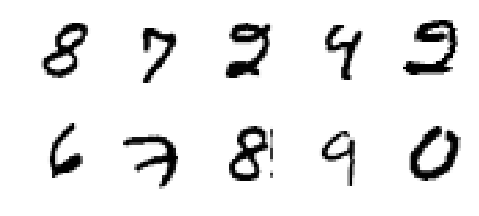

In [15]:
# Als Backup: [4, 13, 1, 2, 27, 3, 0,  9, 8, 7]
examples = [5, 89, 13, 2, 129, 3, 0,  9, 8, 7]

human_precision               = 0.9  # zwischen 0 und 1
machine_precision_enough_time = 0.99    # zwischen 0 und 1
machine_precision_pre_coffee  = 0.80  # zwischen 0 und 1

# ------- Ab hier nichts ändern! ----------
columns = 5
for i, image in enumerate(examples):
    plt.subplot(len(examples) / columns + 1, columns, i + 1)
    plt.imshow(train_data[image].reshape((28, 28)))
    plt.axis("off")

# Modellierung

Für dieses Notebook beschränken wir uns auf ein sehr einfach gehaltenes neuronales Netz. Wir variieren nur zwei Parameter: **a)** die Anzahl der Schichten und **b)** die Anzahl der Neuronen pro Schicht. Unser Ziel ist herauszufinden, wie weit wir mit diesem sehr simplen Ansatz kommen können. Der folgende Codeblock automatisiert den Bau des Netzwerks und muss einmal ausgeführt, aber nicht verstanden werden.

In [16]:
def build_model(no_nodes, no_hidden_layers, input_shape):
  
  # Initialisierung des Netzwerks als sequentielles Model (= Schicht für
  # Schicht) mit entsprechendem Input-Layer (jeder Pixel ein isolierter
  # Datenpunkt).
  
  model = Sequential()
  model.add(Dense(units=no_nodes, input_dim=input_shape))

  # Zusätzliche Anzahl von dichten hidden layers mit konstanter Anzahl von
  # Neuronen. Beispiel: no_nodes = 5 und no_hidden_layers = 3 erzeugt
  # zusätzlich drei Layer mit jeweils fünf Neuronen.
  
  for _ in range(no_hidden_layers):
    model.add(Dense(units=no_nodes))

  # Die finale Schicht normiert die vorhergesagten Wahrscheinlichkeiten
  # über alle zehn möglichen Kategorien auf 100%.
  
  model.add(Dense(units=10, activation='softmax'))
  
  # Die folgenden Details überschreiten den Rahmen dieses Workshops. Kurz
  # gesagt wird hier abschließend definiert auf welche Art das Netzwerk
  # trainiert und optimiert wird. Im Ergbnis gibt die Funktion ein
  # Netzwerk zurück, dass bereit für das eigentliche Training ist.
  
  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  
  return model

**Aufgabe:** ergänzen bzw. verändern Sie die Liste in ```model_combinations``` so, dass insgesamt zehn verschiedene Netzwerkarchitekturen (Kombinationen aus Layern und Neuronen) berechnet werden. **Rein intuitiv: welche Kombination, glauben Sie, wird wie erfolgreich sein?**

**Wichtig:** für diesen Workshop werden wir kein Netzwerk mit mehr als insgesamt 100 Neuronen rechnen, damit die Rechenzeit nicht zu groß wird.

In [26]:
# Für jede gewünschte Variante von Netzwerkarchitekturen bitte hier ein Tuple
# von zwei Werten angeben:
#
#         (Anzahl der hidden Layer, Anzahl der Neuronen pro Layer)
#
# Beim Ausführen der Zelle werden alle Kombinationen einzeln trainiert und
# verschiedene Metriken zur Evaluierung eingesammelt.
#
# Wichtig: der rechnerische Aufwand für das Training wird sehr schnell sehr
#          hoch. Für diesen Workshop ist die Trainingszeit deshalb stark
#          reduziert.

model_combinations = [(1, 1), (2, 50)  ]

# ------ Ab hier nichts verändern! ------

layers = []
nodes = []
evals = []
trains = []
sums = []

for (l, n) in model_combinations:
  
  if(l * n > 100):
    print("Mehr als insgesamt 100 Neuronen wird zu lange dauern.")
    continue
  
  model = build_model(no_nodes=n, no_hidden_layers=l,
                      input_shape=train_data.shape[1])
  model.fit(train_data, train_labels, epochs=3, verbose=0)
  layers.append(l)
  nodes.append(n)
  sums.append(n * l)
  trains.append(model.evaluate(train_data, train_labels, verbose=0)[1])
  evals.append(model.evaluate(eval_data, eval_labels)[1])
                     

# Aufbau der Evaluationstabelle
comparison = pd.DataFrame({"no_layers": layers, "no_nodes": nodes,
                           "sum_nodes": sums, "evaluation_test": evals,
                           "evaluation_training": trains})
                     
comparison["diff_human"] = comparison.evaluation_test - human_precision
comparison["diff_machine_pre_coffee"] = comparison.evaluation_test - machine_precision_pre_coffee
comparison["diff_machine_enough_time"] = comparison.evaluation_test - machine_precision_enough_time
comparison["is_overfitting"] = comparison.evaluation_training > comparison.evaluation_test

comparison = comparison[["no_layers", "no_nodes", "sum_nodes",
                         "evaluation_training", "evaluation_test",
                         "diff_human", "diff_machine_pre_coffee", "diff_machine_enough_time",
                         "is_overfitting"]]

10000/10000 [==============================] - 0s 49us/step


## Evaluation
Nach der Berechnung aller angegebenen Modellvariationen, zeigt die untere Tabelle nun eine Zusammenfassung der verschiedenen Evaluationsmetriken:
- ```no_layers```, ```no_nodes``` und ```sum_nodes``` sind rein deskriptiv.
- ```evaluation_training``` ist die Genauigkeit des Netzes auf den bekannten Daten.
- ```evaluation_test``` ist die Genauigkeit des Netzes auf unbekannten Daten.
- ```diff_XXXX``` ist der Unterschied zu den Einschätzungen in der vorherigen Aufgabe.

**Aufgabe 2:**
- Welche Kombination aus Anzahl der Layer und Neuronen schneidet in ```evaluation_test``` am besten ab? Ist das überraschend? 
- Ist die Anzahl der Schichten oder die der Neuronen wichtiger für das bestmögliche Ergebnis?
- Wie schlagen sich die verschiedenen Netze im Vergleich zu euren vorherigen Erwartungen? Ist der Abstand größer oder kleiner als gedacht?
- Wie sehr würden Sie dem besten Netz in einem realen Usecase vertrauen?

In [27]:
comparison.sort_values("evaluation_test", ascending=False)

,no_layers,no_nodes,sum_nodes,evaluation_training,evaluation_test,diff_human,diff_machine_pre_coffee,diff_machine_enough_time,is_overfitting
1,2,50,100,0.920291,0.9204,0.0204,0.1204,-0.0696,False
0,1,1,1,0.388200,0.3920,-0.5080,-0.4080,-0.5980,False
